<a href="https://colab.research.google.com/github/suubkiim/Image-Captioning/blob/master/Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!ls /content/

drive  sample_data


In [3]:
!ls  /content/drive/'My Drive'/'Colab Notebooks'/neural_image_captioning-master/neural_image_captioning-master/trained_models/IAPR_2012/iapr_weights.90-1.99.hdf5


'/content/drive/My Drive/Colab Notebooks/neural_image_captioning-master/neural_image_captioning-master/trained_models/IAPR_2012/iapr_weights.90-1.99.hdf5'


In [0]:
import os
import sys
sys.path.insert(0, '/content/drive/My Drive/Colab Notebooks/neural_image_captioning-master/neural_image_captioning-master/src')

#### 코드 출처 : https://github.com/oarriaga/neural_image_captioning

## Data preprocessing

In [5]:
import matplotlib.pyplot as plt
from evaluator import Evaluator
from generator import Generator
from keras.callbacks import CSVLogger
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from models import NIC
from data_manager import DataManager
from keras.models import load_model

%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 18)
plt.rcParams['image.interpolation'] = 'nearest'

Using TensorFlow backend.


In [0]:
num_epochs = 500
batch_size = 256
root_path = '/content/drive/My Drive/Colab Notebooks/neural_image_captioning-master/neural_image_captioning-master/datasets/IAPR_2012/'
captions_filename = root_path + 'IAPR_2012_captions.txt'
data_manager = DataManager(data_filename=captions_filename,
                            max_caption_length=30,
                            word_frequency_threshold=2,
                            extract_image_features=False,
                            cnn_extractor='inception',
                            image_directory=root_path + 'iaprtc12/',
                            split_data=True,
                            dump_path=root_path + 'preprocessed_data/')

In [7]:
data_manager.preprocess()
print(data_manager.captions[0])
print(data_manager.word_frequencies[0:20])

Loading data ...
Loaded 19625 captions
Removing captions longer than 30 ...
Number of files removed: 1047
Current number of files: 18578
Removing words with a frequency less than 2 ...
Number of words removed: 1971
Current number of words: 2166
['two', 'black', 'and', 'white', 'penguins', 'on', 'grey', 'rocks']
[['a' '40160']
 ['and' '14910']
 ['in' '14609']
 ['with' '14211']
 ['the' '11373']
 ['on' '9232']
 ['of' '8381']
 ['brown' '6398']
 ['are' '5271']
 ['grey' '5163']
 ['is' '4111']
 ['white' '3594']
 ['green' '3447']
 ['standing' '3447']
 ['foreground' '3228']
 ['blue' '2803']
 ['black' '2697']
 ['at' '2651']
 ['front' '2505']
 ['two' '2455']]


In [0]:
################################################
#####           Generator 재정의           #####
################################################

import pickle
import random

import h5py
import numpy as np
import pandas as pd

class Generator():
    """ Data generator to the neural image captioning model (NIC).
    The flow method outputs a list of two dictionaries containing
    the inputs and outputs to the network.
    # Arguments:
        data_path = data_path to the preprocessed data computed by the
            Preprocessor class.
    """
    def __init__(self,data_path='preprocessed_data/',
                 training_filename=None,
                 validation_filename=None,
                 image_features_filename=None,
                 batch_size=100):

        self.data_path = data_path
        if training_filename == None:
            self.training_filename = data_path + 'training_data.txt'
        else:
            self.training_filename = self.data_path + training_filename


        if validation_filename == None:
            self.validation_filename = data_path + 'validation_data.txt'
        else:
            self.validation_filename = self.data_path + validation_filename

        if image_features_filename == None:
            self.image_features_filename = (data_path +
                                            'inception_image_name_to_features.h5')
        else:
            self.image_features_filename = self.data_path + image_features_filename


        self.dictionary = None
        self.training_dataset = None
        self.validation_dataset = None
        self.image_names_to_features = None

        data_logs = np.genfromtxt(self.data_path + 'data_parameters_r.log',
                                  delimiter='*', dtype='str')
        data_logs = dict(zip(data_logs[:, 0], data_logs[:, 1]))
      
        self.MAX_TOKEN_LENGTH = int(data_logs['max_caption_length:']) + 2
        self.IMG_FEATS = int(data_logs['IMG_FEATS:'])
        self.BOS = str(data_logs['BOS:'])
        self.EOS = str(data_logs['EOS:'])
        self.PAD = str(data_logs['PAD:'])
        self.VOCABULARY_SIZE = None
        self.word_to_id = None
        self.id_to_word = None
        self.BATCH_SIZE = batch_size

        self.load_dataset()
        self.load_vocabulary()
        self.load_image_features()

    def load_vocabulary(self):
        print('Loading vocabulary...')
        word_to_id = pickle.load(open(self.data_path + 'word_to_id.p', 'rb'))
        id_to_word = pickle.load(open(self.data_path + 'id_to_word.p', 'rb'))
        self.VOCABULARY_SIZE = len(word_to_id)
        self.word_to_id = word_to_id
        self.id_to_word = id_to_word

    def load_image_features(self):
        self.image_names_to_features = h5py.File(
                                        self.image_features_filename, 'r')

    def load_dataset(self):

        print('Loading training dataset...')
        train_data = pd.read_table(self.training_filename, delimiter='*')
        train_data = np.asarray(train_data,dtype=str)
        self.training_dataset = train_data

        print('Loading validation dataset...')
        validation_dataset = pd.read_table(
                                self.validation_filename,delimiter='*')
        validation_dataset = np.asarray(validation_dataset, dtype=str)
        self.validation_dataset = validation_dataset

    def return_dataset(self, path=None, dataset_name='all', mode='training'):
        print('Loading dataset in memory...')
        if path == None:
            path = self.data_path
        if mode == 'training':
            data = pd.read_table(self.training_filename, sep='*')
        elif mode == 'test':
            data = pd.read_table(path + 'test_data.txt', sep='*')
        if dataset_name != 'all':
            data = data[data['image_names'].str.contains(dataset_name)]

        data = np.asarray(data)
        data_size = data.shape[0]
        image_names = data[:, 0]
        image_features = np.zeros((data_size,self.MAX_TOKEN_LENGTH,
                                   self.IMG_FEATS))
        image_captions = np.zeros((data_size,self.MAX_TOKEN_LENGTH,
                                   self.VOCABULARY_SIZE))
        target_captions = np.zeros((data_size,self.MAX_TOKEN_LENGTH,
                                   self.VOCABULARY_SIZE))

        for image_arg, image_name in enumerate(image_names):
            caption = data[image_arg,1]
            one_hot_caption = self.format_to_one_hot(caption)
            image_captions[image_arg, :, :] = one_hot_caption
            target_captions[image_arg, :, :] = self.get_one_hot_target(
                                                            one_hot_caption)
            image_features[image_arg, :, :] = self.get_image_features(
                                                            image_name)

        return image_features, image_captions, target_captions,image_names

    def flow(self, mode):

        if mode == 'train':
            data = self.training_dataset
            #random.shuffle(data) #this is probably correct but untested 
        if mode == 'validation':
            data = self.validation_dataset

        image_names = data[:,0].tolist()
        empty_batch = self.make_empty_batch()
        captions_batch = empty_batch[0]
        images_batch = empty_batch[1]
        targets_batch = empty_batch[2]

        batch_counter = 0
        while True:
            for data_arg, image_name in enumerate(image_names):

                caption = data[data_arg,1]
                one_hot_caption = self.format_to_one_hot(caption)
                captions_batch[batch_counter, :, :] = one_hot_caption
                targets_batch[batch_counter, :, :]  = self.get_one_hot_target(
                                                            one_hot_caption)
                images_batch[batch_counter, :, :]   = self.get_image_features(
                                                            image_name)

                if batch_counter == self.BATCH_SIZE - 1:
                    yield_dictionary = self.wrap_in_dictionary(captions_batch,
                                                                images_batch,
                                                                targets_batch)
                    yield yield_dictionary

                    empty_batch = self.make_empty_batch()
                    captions_batch = empty_batch[0]
                    images_batch = empty_batch[1]
                    targets_batch = empty_batch[2]
                    batch_counter = 0

                batch_counter = batch_counter + 1

    def make_test_input(self,image_name=None):

        if image_name == None:
            image_name = random.choice(self.training_dataset[:, 0].tolist())

        one_hot_caption = np.zeros((1, self.MAX_TOKEN_LENGTH,
                                        self.VOCABULARY_SIZE))
        begin_token_id = self.word_to_id[self.BOS]
        one_hot_caption[0, 0, begin_token_id] = 1
        image_features = np.zeros((1, self.MAX_TOKEN_LENGTH, self.IMG_FEATS))
        image_features[0, :, :] = self.get_image_features(image_name)
        return one_hot_caption, image_features, image_name

    def make_empty_batch(self):
        captions_batch = np.zeros((self.BATCH_SIZE,self.MAX_TOKEN_LENGTH,
                                    self.VOCABULARY_SIZE))
        images_batch = np.zeros((self.BATCH_SIZE, self.MAX_TOKEN_LENGTH,
                                    self.IMG_FEATS))
        targets_batch = np.zeros((self.BATCH_SIZE,self.MAX_TOKEN_LENGTH,
                                    self.VOCABULARY_SIZE))
        return captions_batch, images_batch , targets_batch

    def format_to_one_hot(self,caption):
        tokenized_caption = caption.split()
        tokenized_caption = [self.BOS] + tokenized_caption + [self.EOS]
        one_hot_caption = np.zeros((self.MAX_TOKEN_LENGTH,
                                    self.VOCABULARY_SIZE))
        word_ids = [self.word_to_id[word] for word in tokenized_caption
                        if word in self.word_to_id]
        for sequence_arg, word_id in enumerate(word_ids):
            one_hot_caption[sequence_arg,word_id] = 1
        return one_hot_caption

    def get_image_features(self, image_name):
        image_features = self.image_names_to_features[image_name]\
                                            ['image_features'][:]
        image_input = np.zeros((self.MAX_TOKEN_LENGTH, self.IMG_FEATS))
        image_input[0,:] =  image_features
        return image_input

    def get_one_hot_target(self,one_hot_caption):
        one_hot_target = np.zeros_like(one_hot_caption)
        one_hot_target[:-1, :] = one_hot_caption[1:, :]
        return one_hot_target

    def wrap_in_dictionary(self,one_hot_caption,
                           image_features,
                           one_hot_target):

        return [{'text': one_hot_caption,
                'image': image_features},
                {'output': one_hot_target}]




In [16]:
################################################
#####           Evaluator 재정의           #####
################################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import h5py

class Evaluator(object):

    def __init__(self, model,
            data_path='preprocessed_data/',
            images_path='iaprtc12/',
            log_filename='data_parameters_r.log',
            test_data_filename='test_data.txt',
            word_to_id_filename='word_to_id.p',
            id_to_word_filename='id_to_word.p',
            image_name_to_features_filename='inception_image_name_to_features.h5'):
        self.model = model
        self.data_path = data_path
        self.images_path = images_path
        self.log_filename = log_filename
        data_logs = self._load_log_file()
        self.BOS = str(data_logs['BOS:'])
        self.EOS = str(data_logs['EOS:'])
        self.IMG_FEATS = int(data_logs['IMG_FEATS:'])
        self.MAX_TOKEN_LENGTH = int(data_logs['max_caption_length:']) + 2
        self.test_data = pd.read_table(data_path +
                                       test_data_filename, sep='*')
        self.word_to_id = pickle.load(open(data_path +
                                           word_to_id_filename, 'rb'))
        self.id_to_word = pickle.load(open(data_path +
                                           id_to_word_filename, 'rb'))
        self.VOCABULARY_SIZE = len(self.word_to_id)
        self.image_names_to_features = h5py.File(data_path +
                                        image_name_to_features_filename)

    def _load_log_file(self):
        data_logs = np.genfromtxt(self.data_path + 'data_parameters_r.log',
                                  delimiter='* ', dtype='str')
        data_logs = dict(zip(data_logs[:, 0], data_logs[:, 1]))
        return data_logs


    def display_caption(self, image_file=None, data_name=None):

        if data_name == 'ad_2016':
            test_data = self.test_data[self.test_data['image_names'].\
                                            str.contains('ad_2016')]
        elif data_name == 'iaprtc12':
            test_data = self.test_data[self.test_data['image_names'].\
                                            str.contains('iaprtc12')]
        else:
            test_data = self.test_data

        if image_file == None:
            image_name = np.asarray(test_data.sample(1))[0][0]
        else:
            image_name = image_file
        features = self.image_names_to_features[image_name]['image_features'][:]
        text = np.zeros((1, self.MAX_TOKEN_LENGTH, self.VOCABULARY_SIZE))
        begin_token_id = self.word_to_id[self.BOS]
        text[0, 0, begin_token_id] = 1
        image_features = np.zeros((1, self.MAX_TOKEN_LENGTH, self.IMG_FEATS))
        image_features[0, 0, :] = features
        print(self.BOS)
        for word_arg in range(self.MAX_TOKEN_LENGTH - 1):
            predictions = self.model.predict([text, image_features])
            word_id = np.argmax(predictions[0, word_arg, :])
            next_word_arg = word_arg + 1
            text[0, next_word_arg, word_id] = 1
            word = self.id_to_word[word_id]
            print(word)
            if word == self.EOS:
                break
            #images_path = '../dataset/images/'
        plt.imshow(plt.imread(self.images_path + image_name))
        plt.show()

    def write_captions(self, dump_filename=None):
        if dump_filename == None:
            dump_filename = self.data_path + 'predicted_captions.txt'

        predicted_captions = open(dump_filename, 'w')

        image_names = self.test_data['image_names'].tolist()
        for image_name in image_names:

            features = self.image_names_to_features[image_name]\
                                            ['image_features'][:]
            text = np.zeros((1, self.MAX_TOKEN_LENGTH, self.VOCABULARY_SIZE))
            begin_token_id = self.word_to_id[self.BOS]
            text[0, 0, begin_token_id] = 1
            image_features = np.zeros((1, self.MAX_TOKEN_LENGTH,
                                                self.IMG_FEATS))
            image_features[0, 0, :] = features
            neural_caption = []
            for word_arg in range(self.MAX_TOKEN_LENGTH-1):
                predictions = self.model.predict([text, image_features])
                word_id = np.argmax(predictions[0, word_arg, :])
                next_word_arg = word_arg + 1
                text[0, next_word_arg, word_id] = 1
                word = self.id_to_word[word_id]
                if word == '<E>':
                    break
                else:
                    neural_caption.append(word)
            neural_caption = ' '.join(neural_caption)
            predicted_captions.write(neural_caption+'\n')
        predicted_captions.close()
        target_captions = self.test_data['caption']
        target_captions.to_csv(self.data_path + 'target_captions.txt',
                               header=False, index=False)

if __name__ == '__main__':
    from keras.models import load_model

    root_path = '/content/drive/My Drive/Colab Notebooks/neural_image_captioning-master/neural_image_captioning-master/datasets/IAPR_2012/'
    data_path = root_path + 'preprocessed_data/'
    images_path = root_path + 'iaprtc12/'
    model_filename = '/content/drive/My Drive/Colab Notebooks/neural_image_captioning-master/neural_image_captioning-master/trained_models/IAPR_2012/iapr_weights.90-1.99.hdf5'
    model = load_model(model_filename)
    evaluator = Evaluator(model, data_path, images_path)
    #evaluator.write_captions()
    evaluator.display_caption()


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:350: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


<S>
a
garden
with
a
shore
a
shore
and
a
tree
in
the
foreground
<E>


FileNotFoundError: ignored

In [11]:
preprocessed_data_path = root_path + 'preprocessed_data/'
generator = Generator(data_path=preprocessed_data_path,
                      batch_size=batch_size)
num_training_samples =  generator.training_dataset.shape[0]
num_validation_samples = generator.validation_dataset.shape[0]
print('Number of training samples:', num_training_samples)
print('Number of validation samples:', num_validation_samples)

Loading training dataset...
Loading validation dataset...
Loading vocabulary...
Number of training samples: 11889
Number of validation samples: 2973



## NIC model specifications


In [12]:

model = NIC(max_token_length=generator.MAX_TOKEN_LENGTH,
            vocabulary_size=generator.VOCABULARY_SIZE,
            rnn='gru',
            num_image_features=generator.IMG_FEATS,
            hidden_size=256,
            embedding_size=256)

model.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])

print(model.summary())
print('Number of parameters:', model.count_params())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               (None, 32, 2169)     0                                            
__________________________________________________________________________________________________
text_mask (Masking)             (None, 32, 2169)     0           text[0][0]                       
__________________________________________________________________________________________________
image (InputLayer)              (None, 32, 2048)     0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 32, 256)      555520      text_mask[0][0]                  
____________________________________________________________________________________________

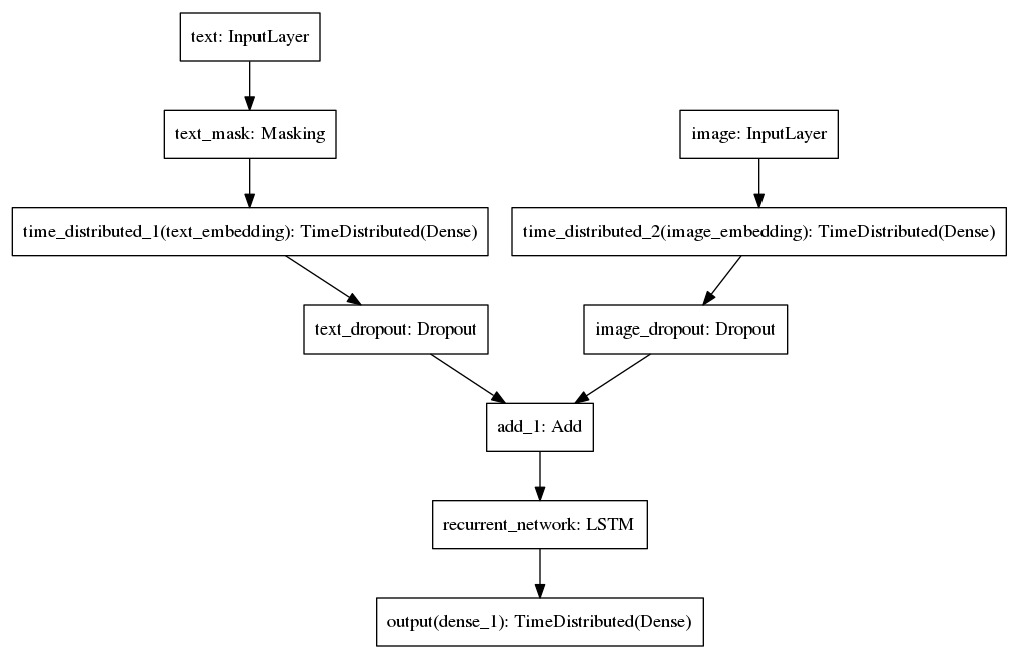

In [13]:
image = plt.imread('/content/drive/My Drive/Colab Notebooks/neural_image_captioning-master/neural_image_captioning-master/images/NIC.png')
plt.imshow(image)
plt.axis('off')
plt.show()

## Testing Model

In [14]:
root_path = '/content/drive/My Drive/Colab Notebooks/neural_image_captioning-master/neural_image_captioning-master/datasets/IAPR_2012/'
data_path = root_path + 'preprocessed_data/'
images_path = root_path + 'iaprtc12/'
model_filename = '/content/drive/My Drive/Colab Notebooks/neural_image_captioning-master/neural_image_captioning-master/trained_models/IAPR_2012/iapr_weights.90-1.99.hdf5'
model = load_model(model_filename)
evaluator = Evaluator(model, data_path, images_path)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:350: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [15]:
evaluator.display_caption()

<S>
tourists
are
sitting
on
a
bars
in
a
room
with
white
walls
and
<E>


FileNotFoundError: ignored

##To Do List

* iaprtc12 다운 후 압축 풀기 > 해당 경로로 옮기기